Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
isDriveUsed = bool(input("Enter 'True' if Google Drive to be used "))

Enter 'True' if Google Drive to be used  


In [3]:
# Defining the path for train and test images if Google Drive is used
## Todo: Update the paths of the train and test dataset
if (isDriveUsed == True):
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_dir_train = pathlib.Path("/content/gdrive/MyDrive/skin_cancer_dataset/Train")
    data_dir_test = pathlib.Path('/content/gdrive/MyDrive/skin_cancer_dataset/Test')
else:
    data_dir_train = pathlib.Path("./skin_cancer_dataset/Train")
    data_dir_test = pathlib.Path('./skin_cancer_dataset/Test')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
data_dir_train

WindowsPath('skin_cancer_dataset/Train')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, label_mode='int', batch_size=batch_size, image_size=(img_height, img_width), seed=123, validation_split=0.2, subset="training")

Found 4039 files belonging to 9 classes.
Using 3232 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_train, label_mode='int', batch_size=batch_size, image_size=(img_height, img_width), seed=123, validation_split=0.2, subset="validation")

Found 4039 files belonging to 9 classes.
Using 807 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

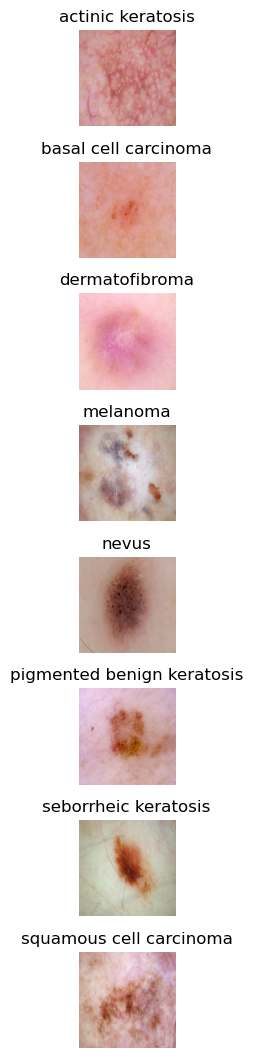

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
### your code goes here, you can use training or validation data to visualize
for i, class_name in enumerate(class_names):
    # Get a batch of images and their corresponding labels
    for images, labels in train_ds.take(1):  # Taking only the first batch
        # Find the indices of images in the current class
        class_indices = tf.where(labels == i)
        # Loop over these images
        if len(class_indices) > 0:
            index = class_indices[0][0].numpy()  # Get the index of the first image in the batch
            img = images[index].numpy()  # Get the image from the batch
            plt.subplot(len(class_names), 1, i + 1)  # Display one image per row
            plt.imshow(img.astype("uint8"))
            plt.title(class_name)
            plt.axis("off")

# Show the images
plt.tight_layout()
plt.show()

In [10]:
# Write code to get image_batch and label_batch
image_batch, label_batch = next(iter(train_ds))
print("Shape of Image Batch - ", image_batch.shape)
print("Shape of Label Batch - ", label_batch.shape)

Shape of Image Batch -  (32, 180, 180, 3)
Shape of Label Batch -  (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the primary model

In [12]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names)))
model.add(layers.Activation('softmax'))

F:\Anaconda\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [13]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    14,451,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,521,385 (55.39 MB)

 Trainable params: 14,521,385 (55.39 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.1547 - loss: 2.1708 - val_accuracy: 0.1574 - val_loss: 2.1407
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.1728 - loss: 2.1485 - val_accuracy: 0.2280 - val_loss: 2.1101
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.1965 - loss: 2.1029 - val_accuracy: 0.2503 - val_loss: 2.0366
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.2234 - loss: 2.0521 - val_accuracy: 0.2330 - val_loss: 2.0447
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.2557 - loss: 1.9886 - val_accuracy: 0.3123 - val_loss: 1.8681
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.2721 - loss: 1.9221 - val_accuracy: 0.3631 - val_loss: 1.8493
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 99s 985ms/step - accuracy: 0.2811 - loss: 1.8990 - val_accuracy: 0.3631 - val_loss: 1.7196
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 100s 987ms/step - accuracy: 0.2868 - loss: 1.8760 - val

### Visualizing training results

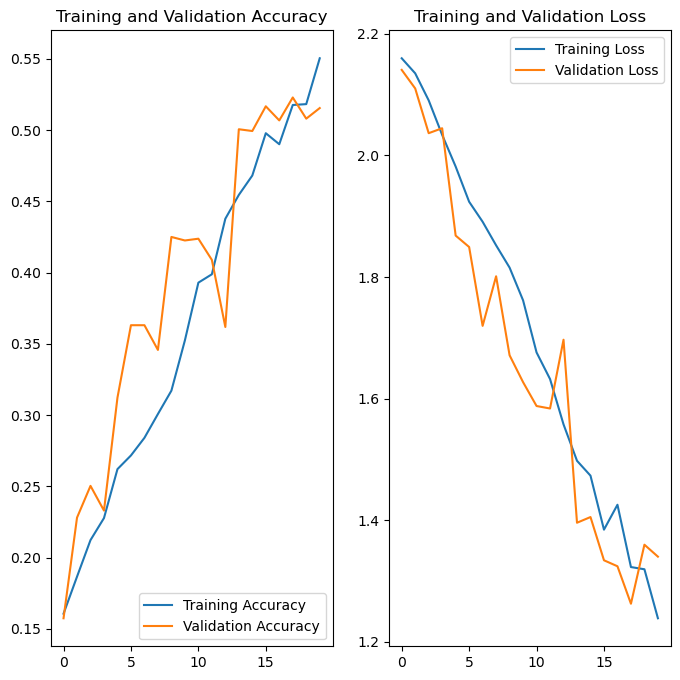

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
1. The training and validation accuracies are average (~55%). The training accuracy slowly increases and validation accuracy also shows the same trend
2. The loss value drops slowly but does not go as low. It stops at around 1.2. Again there isnt much improvement and this model is not fitting well.

### Actions
1. Change the model structure since model has not been able to learn well. Make it more complex
2. Tune hyperparameters like learning rate, optimizer etc

### Using different augmentation strategies and a more complex model

Since these are datasets having images of lesions, small level augmentations should be performed. Random Rotation(Since photos clicked in any angle), Random Zoom (To increase and decrease zoom slightly) and random contrast (to account for various lighting conditions)

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

# Apply augmentation only to training dataset
augmented_train_dataset = train_ds.map(augment)
augmented_train_dataset = augmented_train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

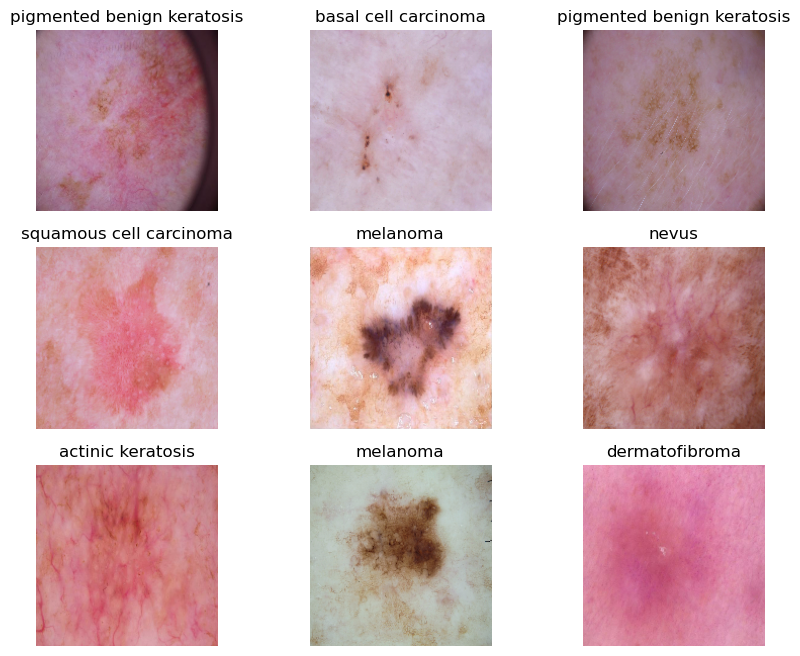

In [18]:
# Visualize before augmentation
plt.figure(figsize=(10,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

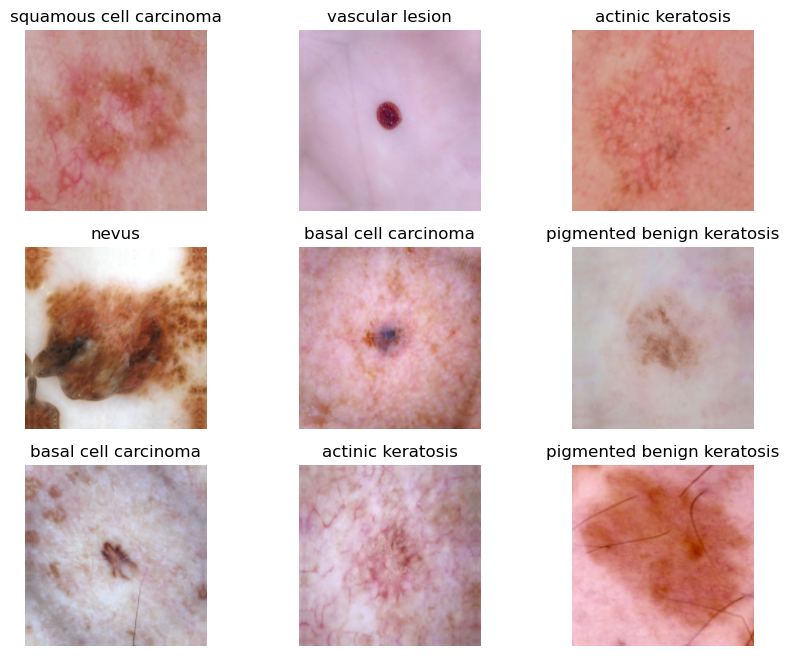

In [19]:
# Visualize how augmentation strategy works for few instances.
plt.figure(figsize=(10,8))
for images, labels in augmented_train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [23]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dense(len(class_names)))
model.add(layers.Activation('softmax'))

In [24]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,194,633 (8.37 MB)

 Trainable params: 2,194,185 (8.37 MB)

 Non-trainable params: 448 (1.75 KB)

### Train the model

In [26]:
epochs = 20
history = model.fit(
  augmented_train_dataset,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.2253 - loss: 2.7142 - val_accuracy: 0.0768 - val_loss: 2.5281
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.4170 - loss: 1.5491 - val_accuracy: 0.0967 - val_loss: 2.5985
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.4794 - loss: 1.3693 - val_accuracy: 0.1660 - val_loss: 2.4911
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.4839 - loss: 1.3626 - val_accuracy: 0.2156 - val_loss: 2.1079
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.5291 - loss: 1.2750 - val_accuracy: 0.3792 - val_loss: 1.6087
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.5428 - loss: 1.1802 - val_accuracy: 0.4362 - val_loss: 1.4889
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.5840 - loss: 1.1059 - val_accuracy: 0.4895 - val_loss: 1.3092
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.5897 - loss: 1.0788 - val_accu

### Visualizing the results

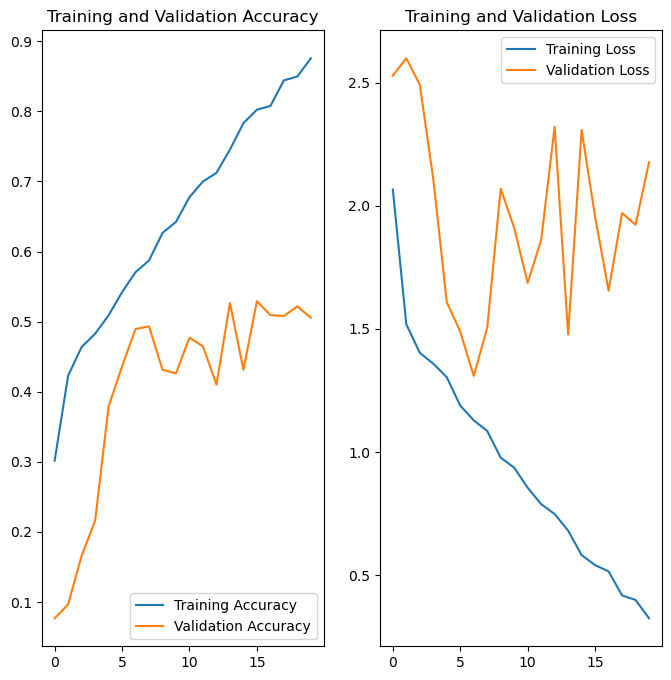

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
There is good improvement in the model even after adding few Convolution layers, batch normalization and adding image augmentation to the training dataset. The training accuracy has improved very much to around 88%. But the validation accuracy has not reached beyond 55%. Thus the model has overfit

### Find the distribution of classes in the training dataset.

##### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [13]:
# Get number of images in each class in train_ds
from collections import Counter

class_counts = Counter()
for images, labels in train_ds:
    for label in labels:
        class_counts[class_names[label]] += 1

# Print the class-wise counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

squamous cell carcinoma: 305
melanoma: 511
dermatofibroma: 242
pigmented benign keratosis: 513
vascular lesion: 279
nevus: 462
actinic keratosis: 252
seborrheic keratosis: 210
basal cell carcinoma: 458


### Class Imbalance Findings:
##### - seborrheic keratosis has the least number of images - 58
##### - pigmented benign keratosis has the maximum number of images - 370
##### The range of images are pretty high from 58 to 370. Hence there is good amount of class imabalance in this dataset


### Rectify the class imbalance
##### Using `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [18]:
path_to_training_dataset="./skin_cancer_dataset/train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(200)

Initialised with 114 image(s) found.
Output directory set to ./skin_cancer_dataset/train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2BCDAEB2D10>: 100%|██████████| 200/200 [00:01<00:00, 102.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./skin_cancer_dataset/train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2BCE0308510>: 100%|██████████| 200/200 [00:01<00:00, 106.21 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ./skin_cancer_dataset/train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2BCDAE6F5D0>: 100%|██████████| 200/200 [00:01<00:00, 101.82 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ./skin_cancer_dataset/train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2BCECA8F950>: 100%|██████████| 200/200 [00:10<00:00, 19.79 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to ./skin_cancer_dataset/train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2BCECAACD10>: 100%|██████████| 200/200 [00:12<00:00, 15.90 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to ./skin_cancer_dataset/train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2BCE0325010>: 100%|██████████| 200/200 [00:02<00:00, 91.21 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to ./skin_cancer_dataset/train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2BCE02ECB90>: 100%|██████████| 200/200 [00:05<00:00, 35.87 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ./skin_cancer_dataset/train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2BCDAEC0190>: 100%|██████████| 200/200 [00:02<00:00, 83.55 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to ./skin_cancer_dataset/train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2BCE0394E50>: 100%|██████████| 200/200 [00:02<00:00, 79.22 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [19]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

1800


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [20]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['skin_cancer_dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_66df1f3b-33a7-4be5-ba8a-d02876cda5fa.jpg',
 'skin_cancer_dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_a96c694f-9afd-4d6f-b949-7db5c80ed760.jpg',
 'skin_cancer_dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_d688a07a-278a-478a-b96b-c2ffa415ed67.jpg',
 'skin_cancer_dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025953.jpg_af6814f3-ca73-4412-be8a-1f4efcbfa31b.jpg',
 'skin_cancer_dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025957.jpg_705c3a75-390f-4b20-9d4a-644c1b94340a.jpg',
 'skin_cancer_dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025992.jpg_e602efe4-a6e9-48bd-9575-9556fee76ae8.jpg',
 'skin_cancer_dataset\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0026040.jpg_5901a3c6-e8f4-4fb5-8c65-8978740f9c2

In [21]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [22]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [23]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
df2.head(10)

,Path,Label
0,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
1,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
2,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
3,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
4,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
5,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
6,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
7,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
8,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis
9,skin_cancer_dataset\Train\actinic keratosis\ou...,actinic keratosis


In [24]:
df2['Label'].value_counts()

Label
actinic keratosis             200
basal cell carcinoma          200
dermatofibroma                200
melanoma                      200
nevus                         200
pigmented benign keratosis    200
seborrheic keratosis          200
squamous cell carcinoma       200
vascular lesion               200
Name: count, dtype: int64

So, now we have added 200 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor
STEP 1: USING ONLY AUGMENTED IMAGES

In [55]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a dataset

In [109]:
# Moved all the augmented images to a new folder skin_cancer_aug_data
data_dir_train="./skin_cancer_aug_data/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='int',
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1800 files belonging to 9 classes.
Using 1440 files for training.


#### Create training and validation dataset

In [110]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='int',
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1800 files belonging to 9 classes.
Using 360 files for validation.


#### Create THE model

In [111]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
# model.add(layers.Conv2D(32, (3, 3), padding='same'))
# model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dense(len(class_names)))
model.add(layers.Activation('softmax'))

#### Compile the model

In [112]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_23 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_153 (Activation)     │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_154 (Activation)     │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_155 (Activation)     │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_156 (Activation)     │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │     1,982,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_157 (Activation)     │ (None, 256)            │             

 Total params: 2,185,257 (8.34 MB)

 Trainable params: 2,184,873 (8.33 MB)

 Non-trainable params: 384 (1.50 KB)

#### Train your model

In [114]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.1780 - loss: 3.6417 - val_accuracy: 0.1083 - val_loss: 2.3395
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3213 - loss: 1.7517 - val_accuracy: 0.1500 - val_loss: 2.2858
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3693 - loss: 1.6186 - val_accuracy: 0.1083 - val_loss: 2.5028
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4122 - loss: 1.5306 - val_accuracy: 0.1083 - val_loss: 2.4405
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4129 - loss: 1.4720 - val_accuracy: 0.1222 - val_loss: 2.6228
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4165 - loss: 1.5027 - val_accuracy: 0.0944 - val_loss: 2.7434
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4705 - loss: 1.3912 - val_accuracy: 0.1000 - val_loss: 2.5267
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4833 - loss: 1.3351 - val_accuracy: 0.1361 - val_loss:

#### Visualize the model results

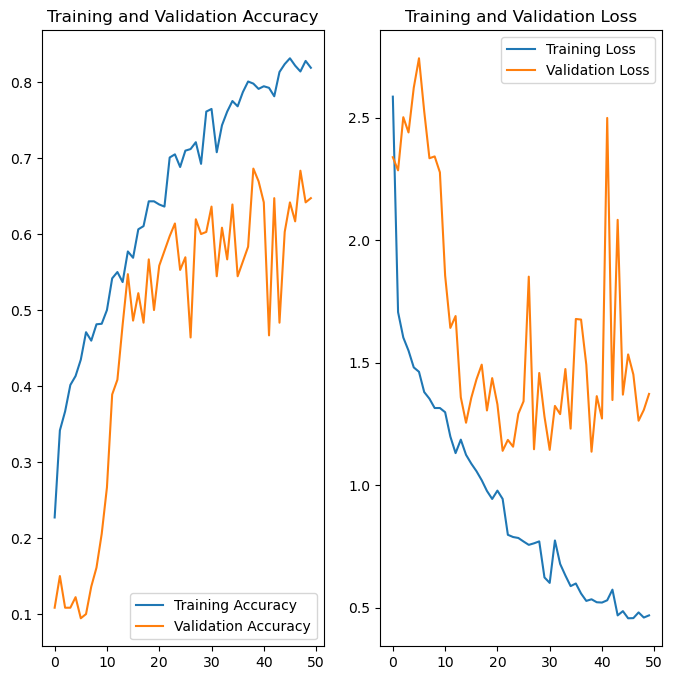

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [116]:
good_model = tf.keras.models.clone_model(model)
good_model.set_weights(model.get_weights())

### Analysis:
#### After class imbalance is taken care of by making sure only 200 images per class are taken, we can see the validation accuracy has also increased more than before. There is a good importance of augmentation and class imbalance



#### STEP 2: Using augmented + actual images

In [119]:
# Using augmented images + actual images
data_dir_train="./skin_cancer_dataset/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='int',
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4039 files belonging to 9 classes.
Using 3232 files for training.


#### Create training and validation dataset

In [120]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  label_mode='int',
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4039 files belonging to 9 classes.
Using 807 files for validation.


#### Creating model

In [121]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dense(len(class_names)))
model.add(layers.Activation('softmax'))

#### Compiling model

In [122]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_24 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_160 (Activation)     │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_161 (Activation)     │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_162 (Activation)     │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │     7,225,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_163 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_164 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 9)              │         4,617 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_165 (Activation)     │ (None, 9)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,390,441 (28.19 MB)

 Trainable params: 7,390,441 (28.19 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
## Defining callback to stop training once train accuracy is above 90% and Val accuracy is also above 80%
train_acc_threshold = 0.90
val_acc_threshold = 0.80

stop_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: 
        model.stop_training if (
            logs.get('accuracy') >= train_acc_threshold and 
            logs.get('val_accuracy') >= val_acc_threshold
        ) else None
)

#### Training

In [124]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[stop_callback]
)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 530ms/step - accuracy: 0.1497 - loss: 2.9333 - val_accuracy: 0.1437 - val_loss: 2.4331
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 497ms/step - accuracy: 0.2150 - loss: 2.3410 - val_accuracy: 0.3482 - val_loss: 1.9136
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 499ms/step - accuracy: 0.3135 - loss: 1.9481 - val_accuracy: 0.3507 - val_loss: 1.9486
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 499ms/step - accuracy: 0.3251 - loss: 1.8380 - val_accuracy: 0.3829 - val_loss: 1.7502
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 499ms/step - accuracy: 0.3636 - loss: 1.7672 - val_accuracy: 0.4312 - val_loss: 1.6388
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 491ms/step - accuracy: 0.3959 - loss: 1.6533 - val_accuracy: 0.4808 - val_loss: 1.5451
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 494ms/step - accuracy: 0.4404 - loss: 1.5543 - val_accuracy: 0.4002 - val_loss: 1.6761
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 494ms/step - accuracy: 0.4244 - loss: 1

#### Visualizing the model results

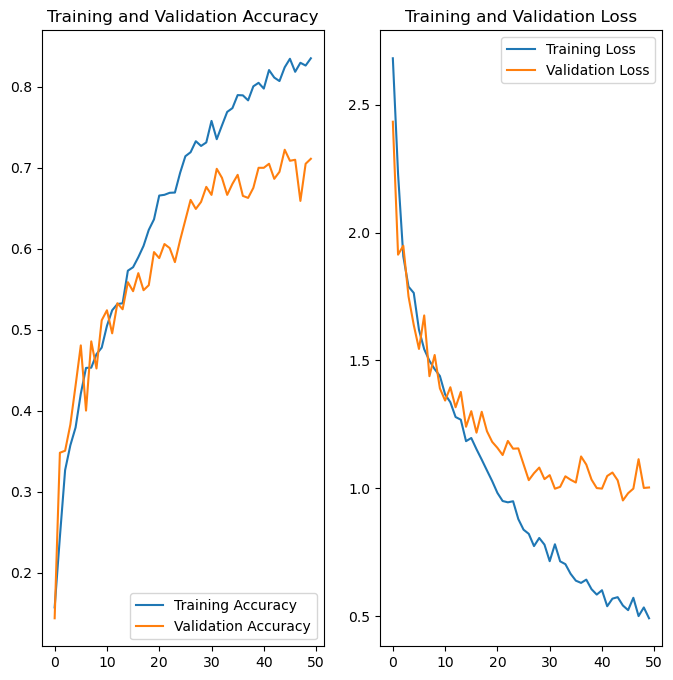

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis:
This seems as a better model after adding both the datasets together for training. We can use this as a better model

In [126]:
good_model_2 = tf.keras.models.clone_model(model)
good_model_2.set_weights(model.get_weights())

### Trying to augment the dataset using some augmentation techniques before sending into the model

In [20]:
augmented_train_dataset = train_ds.map(augment)
augmented_train_dataset = augmented_train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [102]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(32, (3, 3), padding='same' , activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same' , activation=None))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dense(len(class_names)))
model.add(layers.Activation('softmax'))

#### Compiling model

In [103]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_22 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_146 (Activation)     │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_147 (Activation)     │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_148 (Activation)     │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_149 (Activation)     │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 256)            │     1,982,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_150 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,185,129 (8.34 MB)

 Trainable params: 2,184,809 (8.33 MB)

 Non-trainable params: 320 (1.25 KB)

In [104]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1
)

#### Training

In [105]:
epochs = 50

history = model.fit(
  augmented_train_dataset,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[stop_callback, lr_schedule]
)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 100s 937ms/step - accuracy: 0.2043 - loss: 3.4841 - val_accuracy: 0.1846 - val_loss: 2.6075 - learning_rate: 0.0010
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 95s 937ms/step - accuracy: 0.3464 - loss: 1.9455 - val_accuracy: 0.0657 - val_loss: 2.6797 - learning_rate: 0.0010
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 95s 944ms/step - accuracy: 0.3892 - loss: 1.8022 - val_accuracy: 0.0830 - val_loss: 2.9775 - learning_rate: 0.0010
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 95s 936ms/step - accuracy: 0.4124 - loss: 1.6858 - val_accuracy: 0.2342 - val_loss: 2.5272 - learning_rate: 0.0010
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 94s 935ms/step - accuracy: 0.4522 - loss: 1.5468 - val_accuracy: 0.2478 - val_loss: 2.4860 - learning_rate: 0.0010
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 100s 987ms/step - accuracy: 0.4535 - loss: 1.5179 - val_accuracy: 0.3767 - val_loss: 1.7129 - learning_rate: 0.0010
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 97s 958ms/step - accuracy: 0

#### Visualizing the model results

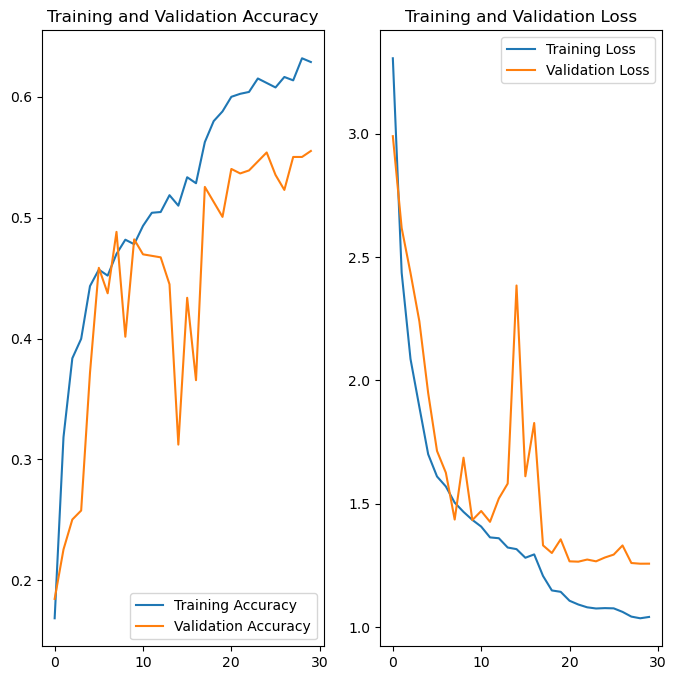

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### End Analysis:
We got the best performing model when we used the augmented + actual dataset. Let us choose that as the best model here

## Prediction

In [90]:
test_ds = image_dataset_from_directory(data_dir_train, label_mode='int', batch_size=batch_size, image_size=(img_height, img_width), seed=123)

Found 4039 files belonging to 9 classes.


In [128]:
predictions = good_model_2.predict(test_ds)
print(predictions.shape)

predicted_classes = tf.argmax(predictions, axis=1)
predicted_classes

127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step
(4039, 9)


<tf.Tensor: shape=(4039,), dtype=int64, numpy=array([6, 5, 6, ..., 8, 1, 7], dtype=int64)>

In [129]:
labels = tf.concat([y for x, y in test_ds], axis=0)
labels = tf.cast(labels, tf.int64)
accuracy = tf.reduce_mean(tf.cast(predicted_classes == labels, tf.float32))
print("Accuracy:", accuracy.numpy())

Accuracy: 0.12082198
